In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sortedcontainers import SortedList
from sklearn.model_selection import train_test_split
import math

In [2]:
df = pd.read_csv('../dataset/rating_final.csv')
df = shuffle(df)

df_train, df_test = train_test_split(df)

In [3]:
user_to_movie = {}
movie_to_user = {}
movie_user_rating = {}
movie_user_rating_train = {}
movie_user_rating_test = {}

bias_movie = {}
bias_user = {}

for row in df.values:
    movie_id, user_id, rate = row
    if movie_id not in user_to_movie:
        user_to_movie[user_id] = [movie_id]
    else:
        user_to_movie[user_id].append(movie_id)
    
    if movie_id not in movie_to_user:
        movie_to_user[movie_id] = [user_id]
    else:
        movie_to_user[movie_id].append(user_id)

    movie_user_rating[(movie_id, user_id)] = rate

average = np.mean(list(movie_user_rating.values()))

for user_id in user_to_movie:
    rates = []
    for movie_id in user_to_movie[user_id]:
        rates.append(movie_user_rating[(movie_id, user_id)] - average)
    bias_user[user_id] = np.mean(rates)

for movie_id in movie_to_user:
    rates = []
    for user_id in movie_to_user[movie_id]:
        rates.append(movie_user_rating[(movie_id, user_id)] - average)
    bias_movie[movie_id] = np.mean(rates)

for row in df_train.values:
    movie_id, user_id, rate = row
    movie_user_rating_train[(movie_id, user_id)] = rate

for row in df_test.values:
    movie_id, user_id, rate = row
    movie_user_rating_test[(movie_id, user_id)] = rate

In [4]:
print(average)
print(bias_movie)
print(bias_user)

8.154840570485153
{'tt0088509': -0.6328893509729575, 'tt3521164': -0.21575427606890898, 'tt0367279': 0.1743901987456164, 'tt7366338': 0.6951594295148478, 'tt8579674': 0.12199866657206791, 'tt0363163': 0.20840267275809052, 'tt0266697': 0.004800685120228362, 'tt0052618': 0.10287371522913308, 'tt0472954': 0.32313561999103807, 'tt0119698': 0.3859202990800651, 'tt0105695': -0.0945785617515283, 'tt0080684': 0.40018588454130216, 'tt15767808': -1.8270627927073748, 'tt0092455': -0.7364195178535737, 'tt0286244': -0.7331014400503699, 'tt0097757': -0.5210377535837442, 'tt0070047': 0.01988470424012212, 'tt0052357': 0.11751237069131838, 'tt3315342': -0.048958217543976286, 'tt1201607': -0.04812916108917953, 'tt1205489': 0.10597575604545957, 'tt15474916': -1.8888307182684039, 'tt2906216': -0.5642422798868618, 'tt0071075': 1.1938550816887605, 'tt0073195': 0.049865311867788475, 'tt7286456': 0.3121085820572206, 'tt13345606': -0.21885155949614163, 'tt1518542': -1.3086867243313063, 'tt1130884': -0.12011003

In [5]:
number_of_movie = int(len(movie_to_user.keys()))
number_of_user = int(len(user_to_movie.keys()))

print(f'Number of movie: {number_of_movie}')
print(f'Number of user: {number_of_user}')

Number of movie: 490
Number of user: 1000


In [6]:
# latent dimensionality
k = 30
W = dict.fromkeys(user_to_movie.keys())
U = dict.fromkeys(movie_to_user.keys())

for user_id in W.keys():
    W[user_id] = np.random.randn(k)
for movie_id in U.keys():
    U[movie_id] = np.random.randn(k)

In [7]:
print(len(W), len(U))

1000 490


In [8]:
def evaluate():
    loss = 0
    for movie_id, user_id in movie_user_rating_test:
        rate = movie_user_rating_test[(movie_id, user_id)]
        error = rate - get_rating(user_id, movie_id)

        loss += error ** 2
    return (loss / len(movie_user_rating_test), math.sqrt(loss / len(movie_user_rating_test)))

def evaluate_with_bias():
    loss = 0
    for movie_id, user_id in movie_user_rating_test:
        rate = movie_user_rating_test[(movie_id, user_id)]
        error = rate - get_rating_with_bias(user_id, movie_id)

        loss += error ** 2
    return (loss / len(movie_user_rating_test), math.sqrt(loss / len(movie_user_rating_test)))

def get_rating(user_id, movie_id):
    return np.dot(W[user_id], U[movie_id])

def get_rating_with_bias(user_id, movie_id):
    return np.dot(W[user_id], U[movie_id]) + average + bias_movie[movie_id] + bias_user[user_id]

In [9]:
interations = 100
learning_rate = 0.01
losses_train = []
losses_validation = []

rmse_train = []
rmse_validation = []

for i in range(0, interations):
    loss = 0    
    for movie_id, user_id in movie_user_rating_train:
        rate = movie_user_rating_train[(movie_id, user_id)]
        
        error = rate - np.dot(W[user_id], U[movie_id])
        
        saved_w = np.copy(W[user_id])
        saved_u = np.copy(U[movie_id])

        W[user_id] += 2 * learning_rate * error * saved_u
        U[movie_id] += 2 * learning_rate * error * saved_w

        loss += error ** 2

    loss = loss / len(movie_user_rating_train)
    rmse = math.sqrt(loss)

    loss_test, rmse_test = evaluate()
    
    losses_train.append(loss)
    losses_validation.append(loss_test)

    rmse_train.append(rmse)
    rmse_validation.append(rmse_test)

    print(f'Epoch: {i + 1}/{interations}')
    print('Loss: ' , loss, 'RMSE: ', rmse, 'Loss_Validation: ', loss_test, 'RMSE_Validation: ', rmse_test)

Epoch: 1/100 Loss:  36.1498399454429 RMSE:  6.012473696029189
Epoch: 2/100 Loss:  3.599128787105654 RMSE:  1.8971369974531764
Epoch: 3/100 Loss:  2.0258841439487445 RMSE:  1.4233355696914007
Epoch: 4/100 Loss:  1.6704261987666773 RMSE:  1.2924496890659525
Epoch: 5/100 Loss:  1.47244597019534 RMSE:  1.2134438471537692
Epoch: 6/100 Loss:  1.3250880003280436 RMSE:  1.1511246675873312
Epoch: 7/100 Loss:  1.2034851468967767 RMSE:  1.0970347063319268
Epoch: 8/100 Loss:  1.099589237603693 RMSE:  1.048613006596663
Epoch: 9/100 Loss:  1.0097301344139615 RMSE:  1.0048532899950926
Epoch: 10/100 Loss:  0.9316331256022089 RMSE:  0.9652114408782196
Epoch: 11/100 Loss:  0.863498334575761 RMSE:  0.9292461108747031
Epoch: 12/100 Loss:  0.8037853981021136 RMSE:  0.8965407955593061
Epoch: 13/100 Loss:  0.7511748295199714 RMSE:  0.8667034265075749
Epoch: 14/100 Loss:  0.704564581168575 RMSE:  0.8393834529990302
Epoch: 15/100 Loss:  0.663049475623674 RMSE:  0.8142785000377168
Epoch: 16/100 Loss:  0.6258908

In [10]:
# interations = 100
# learning_rate = 0.01
# losses_train = []
# losses_validation = []

# rmse_train = []
# rmse_validation = []

# for i in range(0, interations):
#     loss = 0    
#     for movie_id, user_id in movie_user_rating_train:
#         rate = movie_user_rating_train[(movie_id, user_id)]

#         predict_rating = average + bias_movie[movie_id] + bias_user[user_id] + np.dot(W[user_id], U[movie_id])
        
#         error = rate - predict_rating

#         average = average + learning_rate * error

#         bias_movie[movie_id] += learning_rate * (error - 0.2 * bias_movie[movie_id])
#         bias_user[user_id] += learning_rate * (error - 0.2 * bias_user[user_id])
        
#         saved_w = np.copy(W[user_id])
#         saved_u = np.copy(U[movie_id])

#         W[user_id] += learning_rate * (2 * error * saved_u - 0.2 * saved_w)
#         U[movie_id] += learning_rate * (2 * error * saved_w - 0.2 * saved_u)

#         loss += error ** 2

#     loss = loss / len(movie_user_rating_train)
#     rmse = math.sqrt(loss)

#     loss_test, rmse_test = evaluate_with_bias()
    
#     losses_train.append(loss)
#     losses_validation.append(loss_test)

#     rmse_train.append(rmse)
#     rmse_validation.append(rmse_test)

#     print(f'Epoch: {i + 1}/{interations}')
#     print('Loss: ' , loss, 'RMSE: ', rmse, 'Loss_Validation: ', loss_test, 'RMSE_Validation: ', rmse_test)

In [13]:
evaluate()

(6.305512701298405, 2.511077995861221)

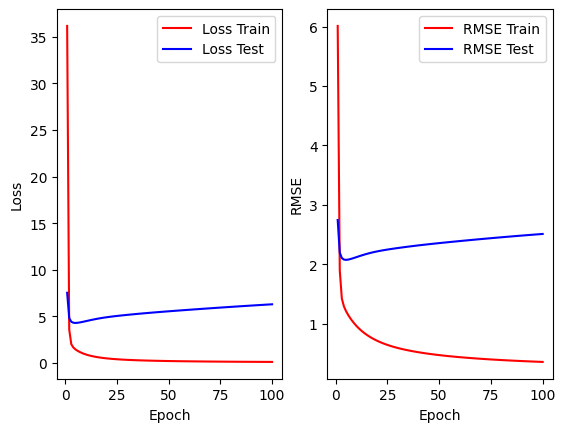

In [14]:
x_axis = list(range(1, interations + 1))
fig, axis = plt.subplots(nrows = 1, ncols = 2)

axis[0].plot(x_axis, losses_train, color = 'red', label = 'Loss Train')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[0].plot(x_axis, losses_validation, color = 'blue', label = 'Loss Test')
axis[0].legend(loc = 'upper right')

axis[1].plot(x_axis, rmse_train, color = 'red', label = 'RMSE Train')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('RMSE')

axis[1].plot(x_axis, rmse_validation, color = 'blue', label = 'RMSE Test')
axis[1].legend(loc = 'upper right')
plt.show()